Welcome to the Jupyter Notebook containing the review code for our first Advanced Workshop. This will have a/ll the important parts of the code we develop and relevant explanations. It also has some sources you can get some better explanations than mine.

In [2]:
# Imports for this workshop:
%matplotlib inline
import numpy as np
from scipy import ndimage
from PIL import Image
from matplotlib.pyplot import imshow
import os

# Linear Classifers #

   In this workshop we'll be taking a bottom up approach to Convolutional Neural Nets, starting with a basic example – the linear classifier. The linear classifier is a function that takes our input vector to our prediction quantities, which we can compare to see what we've predicted. It's called a linear classifier because the prediction matrix is linear:

<center>$Wx^T = p$ </center>

where $W$ is our weight matrix, $x^T$ is a column vector, and $p$ is our prediction. We might also use

<br>
<center>$Wx^T + b = p$ </center>

where $b$ is called the bias (making our classifier affine) but we'll call it linear anyway. For image prediction, because there isn't a matrix that can multiply another matrix to get a vector, we need to unravel our image into a vector. We can do that with this code:

In [3]:
image = np.array([[1,2,3],[4,5,6],[7,8,9]]) # Some arbitrary image matrix
image

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [4]:
fimage = image.flatten()
fimage

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
classifier = np.random.rand(3,fimage.size) # some arbitrary classifier matrix, with 3 rows and 9 columns.
classifier

array([[0.43597693, 0.08774387, 0.61858843, 0.69854032, 0.44922224,
        0.49551985, 0.86731742, 0.85615986, 0.18641292],
       [0.23813162, 0.9952018 , 0.78485486, 0.78924998, 0.04153802,
        0.92858531, 0.52613748, 0.60629249, 0.3166069 ],
       [0.56485564, 0.50237047, 0.52300527, 0.15454692, 0.53355925,
        0.56355294, 0.49164918, 0.53387962, 0.08143612]])

In [6]:
p = np.dot(classifier, fimage)

which would be our prediction vector. We'd take the max of these as our prediction:

In [7]:
prediction = np.argmax(p)
prediction

0

Let's try this with a real example. This code loads in the first MNIST image, a picture of a handwritten 0, and flattens it.

In [8]:
im = np.asarray(Image.open('data/train/000001-num0.png')) / 255
im_flat = im.flatten()

Let's multiply it by a classifier (which is just a random matrix for now, since we haven't decided how to pick the weights of the classfier):

In [9]:
classifier = np.random.rand(10,im_flat.size) / im_flat.size
prediction = np.dot(classifier, im_flat)
number = np.argmax(prediction, axis=0)
number

2

Obviously, since the weights of our classifier matrix are random, every time we try this, we'll get a different prediction. Now, we figure out how to "train" the weights of the classifier matrix. The general procedure of learning is:

<img src="pic/machinelearning.jpeg" style="width: 500px;">

The loss function takes our prediction and the actual labels, called "ground-truth" labels, to a single value which represents how good our predictions are. Generally, our loss function will return zero if they are the same, and some large value if they are very different. What is in between these two extremes can be chosen according to our preferences during learning: we might want to penalize certain types of weights in our network more, or penalize certain types of predictions less if we think they are leading us in the right direction. 

In this workshop, we'll use the cross-entropy loss function. The specifics of why this is chosen are not important, just know that this loss function is generally used for categorization problems.

Essentially, we are dealing with an optimization problem in which we must minimize the loss by improving the weights in our matrix. We can solve this optimization problem with several methods, but a common method used in machine learning is gradient descent, which is what we'll use later for our convolutional neural nets.

In [10]:
# Loss Functions
def CCEntropy(prediction, groundtruth):
    return(-np.sum(groundtruth * np.log(prediction)))

def L2Norm(prediction, groundtruth):
    return(np.sum(np.sqrt(np.square(prediction) + np.square(groundtruth))))

def softmax(prediction):
    return(np.exp(prediction) / sum(np.exp(prediction)))

In [16]:
# Data Loader
def data():
    images = []
    groundtruths = []
    for file in os.listdir("data/train/"):
        n = int(file[10])
        images.append(np.asarray(Image.open("data/train/" + file)) / 255)
        groundtruths.append(np.asarray((n)*[0] + [1] + (1 - n)*[0])) #literally do not ever do this
    print("Data Loaded")
    return(images, groundtruths)

images, groundtruths = data()


Data Loaded


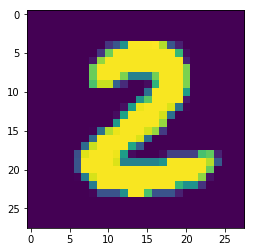

In [18]:
imshow(images[3])

In [ ]:
## Training our linear classifier
# Honestly, this thing is impossible to get to work. 
# I think my gradient formula is bad, but I've tried everything and either 
# my gradients explode or they go to zero real quick. 
# Maybe you can give this a try. 
# But this code gives an idea of the general training algorithm we would use. 

epoch_loss = []
epochs = 10
learningrate = 0.1

W = (np.random.rand(2,28 * 28) - 0.5) * np.sqrt(6 / (28 * 28 + 2))
b = np.zeros(2)

for epoch in range(epochs):
    for i, image in enumerate(images[1:2]):
        
        groundtruth = groundtruths[i]
        
        # Make prediction
        prediction = np.dot(W, image.flatten()) + b
        prediction = softmax(prediction)
        
        # Calculate Gradients
        dy = 2 * (prediction - groundtruth)
        dW = np.outer(dy, image.flatten())

        # Update Predictor
        W = W - learningrate * dW 
        b = b - learningrate * dy
        #W = np.clip(W,-np.sqrt(6 / (28 * 28 + 2)),np.sqrt(6 / (28 * 28 + 2)))
        
        print(W)
        print(b)

# Convolutional Neural Nets

Here we're going to switch to Pytorch, a machine learning framework. 

In [4]:
import torch
import torchvision


from torch.autograd import Variable
import torch.nn.functional as F

class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(10 * 14 * 14, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.double()
        x = F.relu(self.conv2(F.relu(self.conv1(x)))) #convolve
        x = self.pool(x) #pool
        x = x.view(-1, 10 * 14 *14) #reshape
        x = self.fc2(F.relu(self.fc1(x))) #classifier
        return(x)

In [5]:
def data():
    images = []
    groundtruths = []
    for file in os.listdir("data/train/"):
        n = int(file[10])
        images.append(np.asarray(Image.open("data/train/" + file)) / 255)
        groundtruths.append(np.asarray((n)*[0] + [1] + (9 - n)*[0])) #literally do not ever do this
    print("Data Loaded")
    return(images, groundtruths)
images, groundtruths = data()

Data Loaded


In [ ]:
learning_rate = 0.01
n_epochs = 3
net = CNN().double()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
for epoch in range(n_epochs):        
        for i in range(len(images)):
            inputs, labels = Variable(torch.from_numpy(images[i])), Variable(torch.from_numpy(groundtruths[i]))
            optimizer.zero_grad()
            outputs = net(inputs.unsqueeze(0).unsqueeze(0))
            loss_size = loss(outputs, labels.unsqueeze(0).double())
            loss_size.backward()
            if i % 1000 == 0:
                print(str(i) + " / " + str(len(images)))
            optimizer.step()

0 / 60000
1000 / 60000
2000 / 60000
3000 / 60000
4000 / 60000
5000 / 60000
6000 / 60000
7000 / 60000
8000 / 60000
9000 / 60000
10000 / 60000
11000 / 60000
12000 / 60000
13000 / 60000
14000 / 60000
15000 / 60000
16000 / 60000
17000 / 60000
18000 / 60000
19000 / 60000
20000 / 60000
21000 / 60000
22000 / 60000
23000 / 60000
24000 / 60000
25000 / 60000
26000 / 60000
27000 / 60000
28000 / 60000
29000 / 60000
30000 / 60000
31000 / 60000
32000 / 60000
33000 / 60000
34000 / 60000
35000 / 60000
36000 / 60000
37000 / 60000
38000 / 60000
39000 / 60000
40000 / 60000
41000 / 60000
42000 / 60000
43000 / 60000
44000 / 60000
45000 / 60000
46000 / 60000
47000 / 60000
48000 / 60000
49000 / 60000
50000 / 60000
51000 / 60000
52000 / 60000
53000 / 60000
54000 / 60000
55000 / 60000
56000 / 60000


In [ ]:
optimizer.zero_grad()
prediction = net(torch.from_numpy(images[5]).unsqueeze(0).unsqueeze(0).double())
print(prediction)

[0 0 0 0 0 0 0 1 0 0]


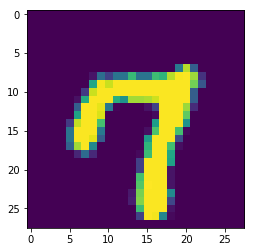

In [11]:
imshow(images[10])
print(groundtruths[10])